<a href="https://colab.research.google.com/github/DommiiUdomp/water-station/blob/main/earthquakes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas

In [ ]:
!pip install keplergl

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import keplergl

In [ ]:
!wget 'https://d32ogoqmya1dw8.cloudfront.net/files/NAGTWorkshops/intro/activities/Continents.zip'

In [ ]:
!wget 'https://data.humdata.org/dataset/4881d82b-ba63-4515-b748-c364f3d05b42/resource/10ac8776-5141-494b-b3cd-bf7764b2f964/download/earthquakes1970-2014.csv'

In [ ]:
!unzip '/content/Continents.zip'

(8, 5)


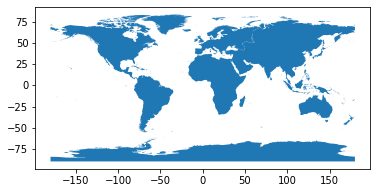

In [2]:
continents = gpd.read_file('/content/Continents/continents.shp')
print(continents.shape)
continents.plot()

In [3]:
earthquakes = pd.read_csv('/content/earthquakes1970-2014.csv')
earthquakes.head()

,DateTime,Latitude,Longitude,Depth,Magnitude,MagType,NbStations,Gap,Distance,RMS,Source,EventID
0,1970/01/04 17:00:40.20,24.139,102.503,31.0,7.5,Ms,90.0,NaN,NaN,0.0,NEI,1.970010e+09
1,1970/01/06 05:35:51.80,-9.628,151.458,8.0,6.2,Ms,85.0,NaN,NaN,0.0,NEI,1.970011e+09
2,1970/01/08 17:12:39.10,-34.741,178.568,179.0,6.1,Mb,59.0,NaN,NaN,0.0,NEI,1.970011e+09
3,1970/01/10 12:07:08.60,6.825,126.737,73.0,6.1,Mb,91.0,NaN,NaN,0.0,NEI,1.970011e+09
4,1970/01/16 08:05:39.00,60.280,-152.660,85.0,6.0,ML,0.0,NaN,NaN,NaN,AK,NaN


In [4]:
earthquakes.set_index('DateTime',inplace =True)
earthquakes.drop(columns=['Gap','Source','EventID','Distance','RMS'],inplace =True)

In [5]:
#SET Major earthquake Magnitude>=7 are Serious damage.
Sdamage = earthquakes[earthquakes['Magnitude']>=7]
Sdamage.info()

<class 'pandas.core.frame.DataFrame'>
Index: 533 entries, 1970/01/04 17:00:40.20 to 2013/11/25 06:27:33.99
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Latitude    533 non-null    float64
 1   Longitude   533 non-null    float64
 2   Depth       533 non-null    float64
 3   Magnitude   533 non-null    float64
 4   MagType     533 non-null    object 
 5   NbStations  527 non-null    float64
dtypes: float64(5), object(1)
memory usage: 29.1+ KB


In [6]:
Sdamage.drop(columns=['NbStations'],inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


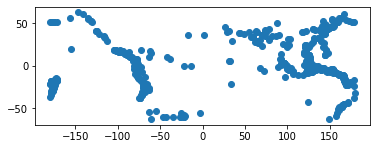

In [7]:
earthquakes_gdf = gpd.GeoDataFrame(Sdamage, 
                                   geometry=gpd.points_from_xy(Sdamage.Longitude, Sdamage.Latitude))
earthquakes_gdf.plot()

# ***GEE Map***

In [ ]:
!pip install geemap

In [ ]:
!pip install geoplot

In [8]:
import geemap

In [9]:
import geoplot

In [ ]:
Map = geemap.Map()
Map

In [60]:
url = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}'
Map.add_tile_layer(url, name='Google Satellite', attribution='Google')

In [63]:
import ee

In [64]:
# Add Earth Engine dataset
dem = ee.Image('USGS/SRTMGL1_003')
landcover = ee.Image("ESA/GLOBCOVER_L4_200901_200912_V2_3").select('landcover')
landsat7 = ee.Image('LE7_TOA_5YEAR/1999_2003')
states = ee.FeatureCollection("TIGER/2018/States")

# Set visualization parameters.
vis_params = {
    'min': 0,
    'max': 4000,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5'],
}

# Add Earth Engine layers to Map
Map.addLayer(dem, vis_params, 'SRTM DEM', True, 0.5)
Map.addLayer(landcover, {}, 'Land cover')
Map.addLayer(
    landsat7, {'bands': ['B4', 'B3', 'B2'], 'min': 20, 'max': 200}, 'Landsat 7'
)
Map.addLayer(states, {}, "US States")

In [73]:
image = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_044034_20140318')

# Define the visualization parameters.
vizParams = {'bands': ['B5', 'B4', 'B3'], 'min': 0, 'max': 0.5, 'gamma': [0.95, 1.1, 1]}

# Center the map and display the image.
Map.setCenter(-122.1899, 37.5010, 10)
# San Francisco Bay
Map.addLayer(image, vizParams, 'False color composite')
Map

Map(bottom=707.0, center=[37.501, -122.1899], controls=(WidgetControl(options=['position', 'transparent_bg'], …

/usr/local/lib/python3.7/dist-packages/geoplot/geoplot.py:885: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for subgeom in geom:


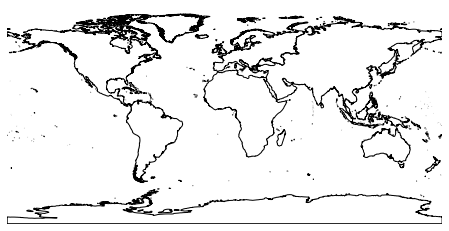

In [10]:
geoplot.polyplot(continents, figsize=(8, 4))

In [11]:
# lat and lon to numeric, errors converted to nan
earthquakes['Longitude'] = pd.to_numeric(earthquakes.Longitude, errors='coerce')
earthquakes['Latitude'] = pd.to_numeric(earthquakes.Latitude, errors='coerce')

In [12]:
earthquakes['FLAG_TSUNAMI'] = (earthquakes['Magnitude'] >=7).astype(int)

In [13]:
data = pd.concat([earthquakes['FLAG_TSUNAMI'] , earthquakes['Longitude'], earthquakes['Latitude'], earthquakes['Magnitude']], axis = 1)

In [ ]:
continents.crs

In [33]:
import matplotlib.pyplot as plt
import contextily as cx

/usr/local/lib/python3.7/dist-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 19 is not valid for the current tile provider (valid zooms: 1 - 16).
  warnings.warn(msg)


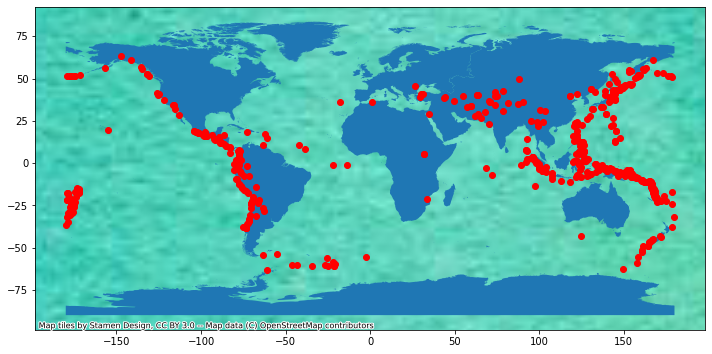

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8), edgecolor='k')
continents.plot(ax=ax)
earthquakes_gdf.plot(ax=ax, color="red")

cx.add_basemap(ax, source=cx.providers.Stamen.Watercolor)
plt.show()